In [276]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from nltk.tokenize import TweetTokenizer,word_tokenize,sent_tokenize,wordpunct_tokenize
from collections import Counter


In [277]:
see=np.load('loss.npy')

In [278]:
import matplotlib.pyplot as plt
%matplotlib inline

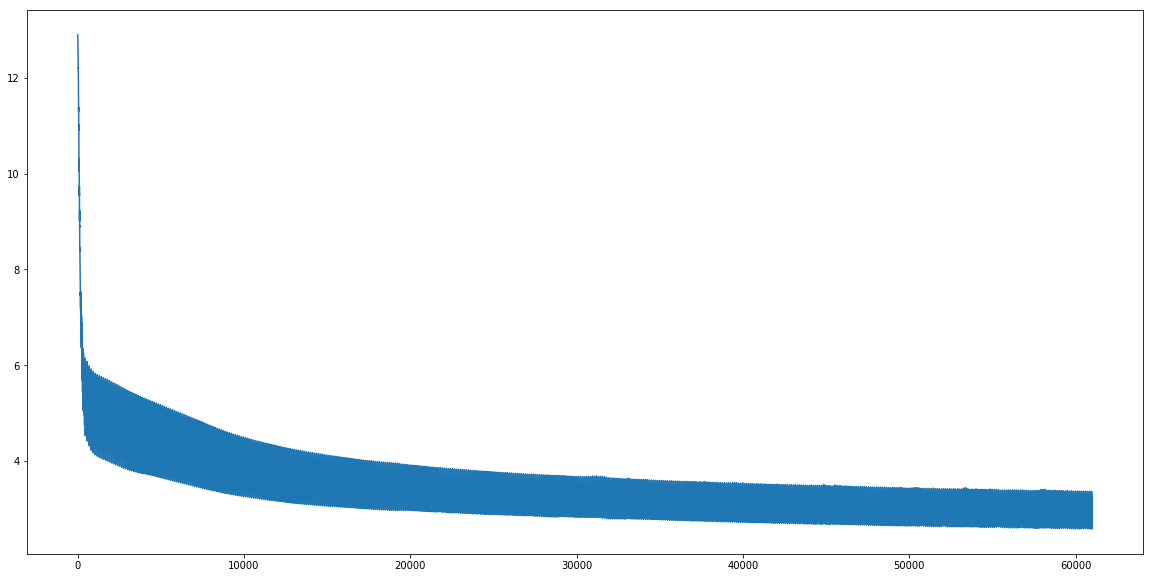

In [279]:
plt.figure(figsize=(20,10))
plt.plot(see)

# Reading Dataset

In [280]:
summ=pd.read_csv('news_summary.csv',encoding='latin')

In [281]:
summ.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [282]:
summ.loc[0]['headlines'] #The content i'll be trying to summarize

'Daman & Diu revokes mandatory Rakshabandhan in offices order'

In [283]:
summ.loc[0]['text']

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [284]:
summ.loc[0]['ctext'] #The content we'll be feeding encoder, and it's the content to be input for summarization

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [285]:
summ.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [286]:
summ.drop(['author','date','read_more','text'],axis=1,inplace=True)

In [287]:
summ.head()

,headlines,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Mumbai and other Indian cities are t...


# Creating word dictionaries, for word embedding(Ignore, used glove embeddings)

# Using Glove embedding to form word vector

In [288]:
embeddings=open('glove.6B.100d.txt','r')

In [289]:
word_embeddings={}
word_list=[]
embed_list=[]

In [290]:
np.shape(word_list)

(0,)

In [291]:
for line in embeddings:
  
    splitline=line.split()
    words=splitline[0]
    word_list.append(words)
    embeddings=np.array([float(i) for i in splitline[1:]])
    embed_list.append(embeddings)
    word_embeddings[words]=embeddings
    

In [292]:
word_list=np.array(word_list)
embed_list=np.array(embed_list)

In [293]:
int_to_word=dict((x,y) for (x,y) in enumerate(word_list))
word_to_int=dict((y,x) for (x,y) in enumerate(word_list))

In [294]:
int_to_word[13075]

'hello'

# Entire Summary and Text have been converted to embeddings, now time to feed em in Encoder and Decoder

In [295]:
summary=[]

passage=[]
for i in summ['headlines']:
    now=wordpunct_tokenize(i)
    now=[i.lower() for i in now]
    summary.append(now)
#     summary_word=np.append(summary_word,wordpunct_tokenize(i))
    
for i in summ['ctext']:
#     passage.append(wordpunct_tokenize(i))
    now=wordpunct_tokenize(str(i))
    now=[i.lower() for i in now]
    passage.append(now)
#     passage_word=np.append(passage_word,wordpunct_tokenize(str(i)))
# summary=np.array(summary)
# passage=np.array(passage)

### So, for now encoder and decoder will be a single layer, with around 20 units each, scaling as moving through

## Lets shape the input dataset for feeding it in the network

In [209]:
len(summary[1])

12

In [210]:
word_to_int['eos']

26828

In [211]:
np.shape(summary)

(4514,)

In [212]:
EOS='eos'
pad='0'

epochs=500

vocab_size = 400000
input_embedding_size = 100
divi=2257
timesteps=int(len(summary)/divi)

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

#### Making sequence length for dynamic rnn

In [213]:
enc_len=[]
dec_len=[]

for i in range(len(summary)):
    dec_len.append(len(summary[i]))
    
for i in range(len(passage)):
    enc_len.append(len(passage[i]))
    
# enc_len=np.reshape(enc_len,(divi,-1))
enc_len = [enc_len[x:x+timesteps] for x in range(0, len(passage),timesteps)]
dec_len = [dec_len[x:x+timesteps] for x in range(0, len(summary),timesteps)]


# dec_len=np.reshape(dec_len,(divi,-1))

In [214]:
# dec_len[0]

#### Making batches of input data for deciding maximum length in a batch

In [215]:
# feed_enc=np.asarray(np.split(passage,divi))#As divi is a factor of 4514 and not very small
# feed_dec=np.asarray(np.split(summary,divi))

feed_enc = [passage[x:x+timesteps] for x in range(0, len(passage),timesteps)]
feed_dec = [summary[x:x+timesteps] for x in range(0, len(summary),timesteps)]





In [216]:
np.shape(feed_enc[0][1])

(477,)

In [217]:

maxlen_enc=np.asarray([max([len(feed_enc[i][j]) for j in range(len(feed_enc[i])) ]) for i in range(len(feed_enc))])

maxlen_dec=np.asarray([max([len(feed_dec[i][j]) for j in range(len(feed_dec[i])) ]) for i in range(len(feed_dec))])

In [218]:
maxlen_enc.shape

(2257,)

In [219]:
len(feed_enc[0][0])

425

## Now we gotta pad the batch, according to maximum length

In [220]:
for i in range(divi):
    for j in range(timesteps):
        
        feed_enc[i][j]+=(pad *(maxlen_enc[i]-len(feed_enc[i][j])))
        feed_dec[i][j]+=(pad *(maxlen_dec[i]-len(feed_dec[i][j])))

In [221]:
np.shape(feed_enc)

(2257, 2)

In [222]:
for i in range(len(feed_enc)):
    for j in range(len(feed_enc[i])):
        for k in range(len(feed_enc[i][j])):
            if feed_enc[i][j][k] in word_embeddings:
                feed_enc[i][j][k]=word_to_int[feed_enc[i][j][k]]
            else:
                feed_enc[i][j][k]=word_to_int['unk']
        
        

In [223]:
for i in range(len(feed_dec)):
    for j in range(len(feed_dec[i])):
        for k in range(len(feed_dec[i][j])):
            if feed_dec[i][j][k] in word_embeddings:
                feed_dec[i][j][k]=word_to_int[feed_dec[i][j][k]]
            else:
                feed_dec[i][j][k]=word_to_int['unk']
        
        

In [224]:
#What we'll feed in encoder
tf.reset_default_graph()

encoder_input=tf.placeholder(dtype=tf.int32,shape=[None,None])
enc_timestep=tf.placeholder(dtype=tf.int32,shape=[None])
decoder_targets=tf.placeholder(dtype=tf.int32,shape=[None,None])
dec_timestep=tf.placeholder(dtype=tf.int32,shape=[None])
decoder_input=tf.placeholder(dtype=tf.int32,shape=[None,None])



In [225]:
emb_enc=tf.nn.embedding_lookup(embed_list,encoder_input)
emb_dec=tf.nn.embedding_lookup(embed_list,decoder_input)

In [226]:
encoder_cell=tf.nn.rnn_cell.BasicLSTMCell(encoder_hidden_units)
decoder_cell=tf.nn.rnn_cell.BasicLSTMCell(decoder_hidden_units)

In [227]:
emb_enc.shape

TensorShape([Dimension(None), Dimension(None), Dimension(100)])

In [228]:
encoder_outputs,encoder_final_state=tf.nn.dynamic_rnn(encoder_cell,
                                                     emb_enc,
                                                      sequence_length=enc_timestep,
                                                      dtype=tf.float64,
                                                     )

In [229]:

'''Ofc, shape of encoder_outputs is somewhat like, 
batch_size,timesteps,number of cells.
Now we wanna feed it in decoder.
'''

decoder_outputs,decoder_final_state=tf.nn.dynamic_rnn(decoder_cell,
                                                     emb_dec,
#                                                       sequence_length=dec_timestep,
                                                     initial_state=encoder_final_state,
                                                      dtype=tf.float64,
                                                      scope='decoder'
                                                     )



In [230]:
np.shape(feed_enc[0][1])

(477,)

In [231]:
np.shape(feed_dec[1])

(2, 13)

In [232]:
decoder_logits=tf.layers.dense(decoder_outputs,vocab_size)

In [233]:
decoder_prediction=tf.argmax(decoder_logits,axis=2)

In [234]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(
                                                        labels=tf.one_hot(decoder_targets,depth=vocab_size,dtype=tf.float32),
                                                        logits=decoder_logits)
loss=tf.reduce_mean(cross_entropy)
train_operation=tf.train.AdamOptimizer().minimize(loss)

In [235]:
feed_enc[0][0]

[0,
 72876,
 5,
 84868,
 466,
 13,
 177,
 4899,
 7,
 9713,
 12,
 476,
 266,
 821,
 4,
 2668,
 201534,
 13,
 2323,
 3296,
 49,
 0,
 460,
 4609,
 7,
 10608,
 25,
 1242,
 5,
 15,
 8366,
 2725,
 13,
 659,
 493,
 2,
 0,
 354,
 1456,
 188,
 1534,
 466,
 15,
 1011,
 4,
 5963,
 425,
 795,
 606,
 3,
 7728,
 0,
 9713,
 12,
 116,
 20,
 12009,
 10,
 47,
 821,
 4,
 4686,
 201534,
 22,
 9069,
 201534,
 20,
 31,
 51,
 847,
 4,
 4686,
 0,
 1427,
 3,
 201534,
 13,
 510,
 632,
 2,
 6,
 37,
 2540,
 1,
 64,
 2087,
 274,
 4630,
 5284,
 944,
 310,
 5,
 4686,
 0,
 1427,
 11266,
 22,
 7,
 7088,
 79,
 21640,
 64,
 0,
 2791,
 821,
 5284,
 2668,
 201534,
 4,
 44,
 3296,
 201534,
 0,
 460,
 1,
 1101,
 13,
 510,
 176,
 21,
 210669,
 3678,
 1,
 1056,
 497,
 23,
 2075,
 201534,
 40,
 16,
 2,
 4,
 1810,
 12,
 84,
 48,
 14990,
 283,
 1,
 29,
 5414,
 255,
 15,
 4,
 30,
 688,
 4,
 0,
 78,
 0,
 182,
 1738,
 2,
 0,
 55,
 51033,
 188,
 48,
 31295,
 0,
 4618,
 3,
 201534,
 23,
 218,
 24,
 5,
 0,
 68,
 9626,
 0,
 4401,
 23,


In [236]:
saver=tf.train.Saver()
loss_track=[]
x=False
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if(tf.train.checkpoint_exists("models/model.ckpt")):
        saver.restore(sess, "models/model.ckpt")
    for j in range(1):
        for i in range(1):
            target=[(sequence)+[word_to_int[EOS]] for sequence in feed_dec[i]]
            dinput=[[word_to_int[EOS]]+(sequence) for sequence in feed_dec[i]]
            
            losss,train=sess.run([loss,train_operation],feed_dict={encoder_input:feed_enc[i],
                                                                           enc_timestep:enc_len[i],
                                                                   decoder_input:dinput,
                                                                   decoder_targets:target
                                                    
                                                                           
                                                                          } )
            print(losss)
            loss_track.append(losss)
# #         save=saver.save(sess, "models/model.ckpt")
        
#             x=tf.train.save_path = saver.save(sess, "/tmp/model.ckpt")
#             x=tf.train.checkpoint_exists("/tmp/model.ckpt")


           
# dec_output,state=sess.run([decoder_outputs,decoder_final_state],feed_dict={})
            


# For each batch, consider last batch with 122 samples. So enc_len[-1][121]=319. So this will mean that till 318, thats 
# coz index start from 0. We'll have values, after which we'll have 0, as we've specified enc_len, which is going to make
# sure that after 318 we don't factor things in our further calculations.


# ALso, for example in output here, with shape 122,1384,20 and state.h having shape of 122,20. lets take example of 
# last batch, 2nd sample, that's output[1][99](as enc_len[-1][1] as value of 99) will have same value as 
# state.h[1]. As state.h just finds last value of rnn and output is value of rnn at all timesteps for all cells,
# np.save('loss.npy',np.array(loss_track))



INFO:tensorflow:Restoring parameters from models/model.ckpt
4.4624903012884785


## Prediction

In [275]:
saver=tf.train.Saver()
loss_track=[]
pred=[]
x=False
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if(tf.train.checkpoint_exists("models/model.ckpt")):
        saver.restore(sess, "models/model.ckpt")
    for j in range(10):
        for i in range(2):
            target=[(sequence)+[word_to_int[EOS]] for sequence in feed_dec[i]]
            dinput=[[word_to_int[EOS]]+(sequence) for sequence in feed_dec[i]]
            
            prediction=sess.run([decoder_prediction],feed_dict={encoder_input:feed_enc[i],
                                                                           enc_timestep:enc_len[i],
                                                                   decoder_input:dinput
                                                    
                                                                           
                                                                          } )
            print(losss)
            new=np.asarray(prediction,dtype=object)

            for i in range(len(prediction)):
                for j in range(len(prediction[i])):
                    for k in range(len(prediction[i][j])):
                            new[i][j][k]=int_to_word[prediction[i][j][k]]

            print(new)
            loss_track.append(losss)
            pred.append(prediction)
# #         save=saver.save(sess, "models/model.ckpt")
        
#             x=tf.train.save_path = saver.save(sess, "/tmp/model.ckpt")
#             x=tf.train.checkpoint_exists("/tmp/model.ckpt")


           
# dec_output,state=sess.run([decoder_outputs,decoder_final_state],feed_dict={})
            


# For each batch, consider last batch with 122 samples. So enc_len[-1][121]=319. So this will mean that till 318, thats 
# coz index start from 0. We'll have values, after which we'll have 0, as we've specified enc_len, which is going to make
# sure that after 318 we don't factor things in our further calculations.


# ALso, for example in output here, with shape 122,1384,20 and state.h having shape of 122,20. lets take example of 
# last batch, 2nd sample, that's output[1][99](as enc_len[-1][1] as value of 99) will have same value as 
# state.h[1]. As state.h just finds last value of rnn and output is value of rnn at all timesteps for all cells,
# np.save('loss.npy',np.array(loss_track))



INFO:tensorflow:Restoring parameters from models/model.ckpt
4.4624903012884785
[[['unk' 'kumar' 'govt' 'revokes' '2' 'for' "'" 'delhi' 'in' '0' '0' '0'
   '0']
  ['unk' 'arora' 'sonakshi' 'to' "'" 'for' "'" 'hospitality' 'divorcing'
   "'" 'theatres' '0' '0']]]
4.4624903012884785
[[['unk' 's' '-' 's' "'" 'to' 'be' 'saviour' "'" 's' 'unk' '0' '0' '0']
  ['aaj' '-' 'pakad' 'liya' ',' 'santa' 'to' 'shot' ',' 'reintroducing'
   'india' '0' '0' '0']]]
4.4624903012884785
[[['unk' 'kumar' 'govt' 'revokes' '2' 'for' "'" 'delhi' 'in' '0' '0' '0'
   '0']
  ['unk' 'arora' 'sonakshi' 'to' "'" 'for' "'" 'hospitality' 'divorcing'
   "'" 'theatres' '0' '0']]]
4.4624903012884785
[[['unk' 's' '-' 's' "'" 'to' 'be' 'saviour' "'" 's' 'unk' '0' '0' '0']
  ['aaj' '-' 'pakad' 'liya' ',' 'santa' 'to' 'shot' ',' 'reintroducing'
   'india' '0' '0' '0']]]
4.4624903012884785
[[['unk' 'kumar' 'govt' 'revokes' '2' 'for' "'" 'delhi' 'in' '0' '0' '0'
   '0']
  ['unk' 'arora' 'sonakshi' 'to' "'" 'for' "'" 'hospitalit

In [296]:
passage[0]

['the',
 'daman',
 'and',
 'diu',
 'administration',
 'on',
 'wednesday',
 'withdrew',
 'a',
 'circular',
 'that',
 'asked',
 'women',
 'staff',
 'to',
 'tie',
 'rakhis',
 'on',
 'male',
 'colleagues',
 'after',
 'the',
 'order',
 'triggered',
 'a',
 'backlash',
 'from',
 'employees',
 'and',
 'was',
 'ripped',
 'apart',
 'on',
 'social',
 'media',
 '.',
 'the',
 'union',
 'territory',
 '?',
 's',
 'administration',
 'was',
 'forced',
 'to',
 'retreat',
 'within',
 '24',
 'hours',
 'of',
 'issuing',
 'the',
 'circular',
 'that',
 'made',
 'it',
 'compulsory',
 'for',
 'its',
 'staff',
 'to',
 'celebrate',
 'rakshabandhan',
 'at',
 'workplace',
 '.?',
 'it',
 'has',
 'been',
 'decided',
 'to',
 'celebrate',
 'the',
 'festival',
 'of',
 'rakshabandhan',
 'on',
 'august',
 '7',
 '.',
 'in',
 'this',
 'connection',
 ',',
 'all',
 'offices',
 '/',
 'departments',
 'shall',
 'remain',
 'open',
 'and',
 'celebrate',
 'the',
 'festival',
 'collectively',
 'at',
 'a',
 'suitable',
 'time',
 'wh

In [270]:
np.shape(pred)

ValueError: could not broadcast input array from shape (2,13) into shape (2)

In [271]:
prediction[0][1]

array([ 66214,     11, 373804, 165300,      1,   2669,      4,    635,
            1,  64600,    474,   1343,   1343,   1343])

In [272]:
new=np.asarray(prediction,dtype=object)

ValueError: could not broadcast input array from shape (2,13) into shape (2)

In [273]:
new=np.asarray(prediction,dtype=object)

for i in range(len(prediction)):
    for j in range(len(prediction[i])):
        for k in range(len(prediction[i][j])):
                new[i][j][k]=int_to_word[prediction[i][j][k]]
                
print(new)

In [274]:

new

array([[['unk', 's', '-', 's', "'", 'to', 'be', 'saviour', "'", 's',
         'unk', '0', '0', '0'],
        ['aaj', '-', 'pakad', 'liya', ',', 'santa', 'to', 'shot', ',',
         'reintroducing', 'india', '0', '0', '0']]], dtype=object)